#### Download the Pascal-VOC dataset from [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit)

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt

## Section 1: Load Pascal-VOC dataset


In [2]:
import os
import cv2
import numpy as np
from xml.etree import ElementTree as ET
from torchvision import transforms
import collections

train_dir = 'train_dir/VOCdevkit/VOC2012'
test_dir = 'test_dir/VOCdevkit/VOC2012'

PASCAL_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

class PascalVOCDataset(torch.utils.data.Dataset):
  def __init__(self, train_dir, width, height, transforms=None):
    self.transforms = transforms
    self.train_dir = train_dir
    self.height = height
    self.width = width
  
    self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

    self.img_paths = list(sorted(os.listdir(os.path.join(self.train_dir, "JPEGImages"))))
    self.ann_paths = list(sorted(os.listdir(os.path.join(self.train_dir, "Annotations")))) 

  def __getitem__(self, idx):
    try:
      img_path = os.path.join(self.train_dir, "JPEGImages", self.img_paths[idx])
      ann_path = os.path.join(self.train_dir, "Annotations", self.ann_paths[idx])

      #TODO: Converting image to correct size
      img_color = torchvision.io.read_image(img_path)
      img_res = torchvision.transforms.functional.resize(img_color, [480,480],antialias=True)
      img_res = torch.div(img_res,255.0)    

      #TODO Extract the necessary information from xml files - bounding box coordinates, label, area, image_id
      target = {"bndboxes": [], "labels" : [], "area" : [], "image_id" : []}
      boxes = []
      labels = []
      areas = []
      image_id = []

      tree = ET.parse(ann_path)
      root = tree.getroot()

      height = img_res.shape[1]
      width = img_res.shape[2]

      for obj in root.iter("object"):
        label = obj.find("name").text
        bounding_box = obj.find("bndbox")
        x_min = int(float(bounding_box.find("xmin").text))
        y_min = int(float(bounding_box.find("ymin").text))
        x_max = int(float(bounding_box.find("xmax").text))
        y_max = int(float(bounding_box.find("ymax").text))

        xmin = (x_min/width)*self.width
        xmax = (x_max/width)*self.width
        ymin = (y_min/height)*self.height
        ymax = (y_max/height)*self.height

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(self.classes.index(label))
        areas.append((x_max - x_min) * (y_max - y_min))
      
      boxes = torch.tensor(boxes, dtype=torch.float32)
      labels = torch.tensor(labels, dtype=torch.int64)
      areas = torch.tensor(areas, dtype=torch.float32)
      image_id = idx

      target = {"boxes": boxes, "labels" : labels, "area" : areas, "image_id" : image_id, "iscrowd":torch.tensor([0]*len(labels))}
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        raise e

    return img_res, target

  def __len__(self):
    return len(self.img_paths)

## Section 2: Define Pre-trained Object Detection Model

In [3]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#import other models as well

def getPretrainedModel(num_classes):
  #TODO: load a pre-trained model and replace the pre-trained head with a new one.
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  
  return model 

## Section 3: Prepare Dataset and Train the model



In [4]:
traindataset = PascalVOCDataset(train_dir, 480, 480, transforms = T.ToTensor())
subset_indices = range(1000)
traindataset = torch.utils.data.Subset(traindataset, subset_indices)


torch.manual_seed(1)
# TODO: split the dataset in train and test set
train_size = int(0.8 * len(traindataset))
test_size = len(traindataset) - train_size
train_data, test_data = random_split(traindataset, [train_size, test_size])
print(f'Length of traindata -- {len(train_data)} and testdata -- {len(test_data)}')

def collate_fn(data):
    images = []
    targets = []
    for i in data:
      images.append(i[0])
      targets.append(i[1])
    return torch.utils.data.default_collate(images), targets

batchSize = 5

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True, num_workers=2, collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batchSize, shuffle=False, num_workers=2, collate_fn=collate_fn)

Length of traindata -- 800 and testdata -- 200


In [5]:
# these are the helper libraries imported.
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [6]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [7]:
from engine import train_one_epoch, evaluate

#TODO: Declare your hyperparameters
lr = 0.001
w_d = 0.0005
num_classes = 20
PATH_TO_FASTER_RCNN = "./FasterRCNN.pt"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = getPretrainedModel(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=w_d)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10
epoch_accuracies = []

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/studio-lab-user/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 461MB/s] 


In [8]:
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, trainloader, device, epoch, print_freq=10)

    lr_scheduler.step()

    evaluate(model, testloader, device=device)

Epoch: [0]  [  0/160]  eta: 0:03:47  lr: 0.000007  loss: 3.5709 (3.5709)  loss_classifier: 3.1011 (3.1011)  loss_box_reg: 0.2171 (0.2171)  loss_objectness: 0.2018 (0.2018)  loss_rpn_box_reg: 0.0509 (0.0509)  time: 1.4236  data: 0.2279  max mem: 1434
Epoch: [0]  [ 10/160]  eta: 0:01:10  lr: 0.000070  loss: 3.5351 (3.4522)  loss_classifier: 3.0064 (3.0276)  loss_box_reg: 0.1640 (0.1796)  loss_objectness: 0.2018 (0.2107)  loss_rpn_box_reg: 0.0266 (0.0342)  time: 0.4730  data: 0.0271  max mem: 1450
Epoch: [0]  [ 20/160]  eta: 0:01:00  lr: 0.000133  loss: 3.1157 (3.0557)  loss_classifier: 2.7161 (2.6418)  loss_box_reg: 0.1502 (0.1720)  loss_objectness: 0.2308 (0.2136)  loss_rpn_box_reg: 0.0208 (0.0283)  time: 0.3792  data: 0.0078  max mem: 1450
Epoch: [0]  [ 30/160]  eta: 0:00:53  lr: 0.000196  loss: 1.8087 (2.4720)  loss_classifier: 1.4076 (2.0704)  loss_box_reg: 0.1608 (0.1747)  loss_objectness: 0.1810 (0.2005)  loss_rpn_box_reg: 0.0181 (0.0263)  time: 0.3794  data: 0.0078  max mem: 1450


In [9]:
torch.save(model.state_dict(), PATH_TO_FASTER_RCNN)

In [10]:
model = getPretrainedModel(num_classes)
model.load_state_dict(torch.load(PATH_TO_FASTER_RCNN))
model.to(device)
evaluate(model, testloader, device=device)

creating index...
index created!
Test:  [ 0/40]  eta: 0:00:25  model_time: 0.4436 (0.4436)  evaluator_time: 0.0250 (0.0250)  time: 0.6309  data: 0.1576  max mem: 1451
Test:  [39/40]  eta: 0:00:00  model_time: 0.3731 (0.3740)  evaluator_time: 0.0129 (0.0151)  time: 0.3991  data: 0.0071  max mem: 1451
Test: Total time: 0:00:16 (0.4051 s / it)
Averaged stats: model_time: 0.3731 (0.3740)  evaluator_time: 0.0129 (0.0151)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=

## Section 4: Test the model

In [11]:
%matplotlib inline
import matplotlib.patches as patches
from torchvision import transforms as torchtrans  

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)
    plt.show()

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [12]:
#TODO: Pick an one image from the test set and print it's precidition as well as the bounding box using above helper functions.
images = next(iter(testloader))
print(images[1])

[{'boxes': tensor([[110., 269., 500., 375.],
        [ 52., 230., 140., 375.]]), 'labels': tensor([10,  8]), 'area': tensor([41340., 12760.]), 'image_id': 109, 'iscrowd': tensor([0, 0])}, {'boxes': tensor([[133., 250., 274., 424.],
        [255., 246., 316., 385.],
        [ 57., 218.,  86., 258.],
        [ 82., 203., 101., 242.],
        [100., 176., 156., 280.]]), 'labels': tensor([12, 12, 14, 14, 14]), 'area': tensor([24534.,  8479.,  1160.,   741.,  5824.]), 'image_id': 629, 'iscrowd': tensor([0, 0, 0, 0, 0])}, {'boxes': tensor([[ 75.,  43., 206., 496.],
        [181.,  62., 211., 132.],
        [  3.,  27., 248., 394.],
        [242.,  77., 375., 280.]]), 'labels': tensor([14,  4, 17, 17]), 'area': tensor([59343.,  2100., 89915., 26999.]), 'image_id': 174, 'iscrowd': tensor([0, 0, 0, 0])}, {'boxes': tensor([[ 71., 129., 331., 499.],
        [171., 196., 330., 486.]]), 'labels': tensor([14, 14]), 'area': tensor([96200., 46110.]), 'image_id': 398, 'iscrowd': tensor([0, 0])}, {'boxe

{'boxes': tensor([[ 75.,  43., 206., 496.],
        [181.,  62., 211., 132.],
        [  3.,  27., 248., 394.],
        [242.,  77., 375., 280.]]), 'labels': tensor([14,  4, 17, 17]), 'area': tensor([59343.,  2100., 89915., 26999.]), 'image_id': 174, 'iscrowd': tensor([0, 0, 0, 0])}


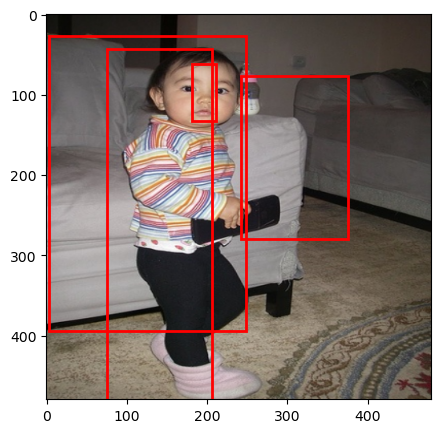

In [13]:
imageIdx = 2
print(images[1][imageIdx])
plot_img_bbox(torch_to_pil(images[0][imageIdx]), images[1][imageIdx])

In [14]:
print(images[0][0].shape)

cpu_device = torch.device("cpu")
model = getPretrainedModel(num_classes)
model.load_state_dict(torch.load(PATH_TO_FASTER_RCNN))
model.to(cpu_device)
model.eval()
output = model(images[0])

torch.Size([3, 480, 480])


{'boxes': array([[ 95.38258 ,  36.73116 , 291.38116 , 351.29694 ],
       [  0.      ,  14.254167, 135.79904 , 183.87532 ],
       [304.20422 ,  66.00721 , 468.97104 , 207.87334 ],
       [241.41876 ,  56.23496 , 271.45422 ,  98.9141  ],
       [128.61996 ,  45.706856, 256.15353 , 109.24386 ],
       [139.19687 , 212.70734 , 297.10318 , 268.0473  ]], dtype=float32), 'labels': array([14, 14, 14, 14, 14, 14]), 'scores': array([0.78805846, 0.23696698, 0.21105614, 0.11046513, 0.10741935,
       0.05266938], dtype=float32)}
{'boxes': tensor([[110., 269., 500., 375.],
        [ 52., 230., 140., 375.]]), 'labels': tensor([10,  8]), 'area': tensor([41340., 12760.]), 'image_id': 109, 'iscrowd': tensor([0, 0])}


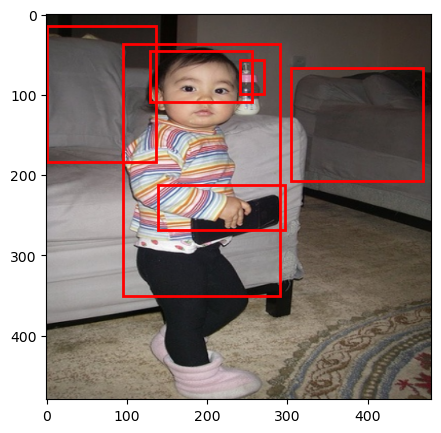

In [15]:
imageIdx= 2
NMS_Output = apply_nms(output[imageIdx], iou_thresh=0.20)
NMS_Output = { k:v.detach().numpy() for k,v in NMS_Output.items() }
print(NMS_Output)
print(images[1][0])
plot_img_bbox(torch_to_pil(images[0][imageIdx]), NMS_Output)

## YOLO

In [1]:
!git clone https://github.com/ultralytics/yolov5.git

%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16572, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 16572 (delta 26), reused 32 (delta 13), pack-reused 16522
Receiving objects: 100% (16572/16572), 15.08 MiB | 39.91 MiB/s, done.
Resolving deltas: 100% (11379/11379), done.
/home/studio-lab-user/sagemaker-studiolab-notebooks/yolov5


In [2]:
!python train.py --img 640 --epochs 3 --data VOC.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=VOC.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.14 torch-2.0.0.post200 CUDA:0 (Tesla T4, 14931MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.

In [3]:
!python val.py --weights "runs/train/exp/weights/best.pt" --data VOC.yaml --img 640

val: data=/home/studio-lab-user/sagemaker-studiolab-notebooks/yolov5/data/VOC.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.14 torch-2.0.0.post200 CUDA:0 (Tesla T4, 14931MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /home/studio-lab-user/sagemaker-studiolab-notebooks/datasets/VOC/l
                 Class     Images  Instances          P          R      mAP50   
                   all       4952      12032      0.754      0.729      0.789      0.509
             aeroplane       4952        285      0.879      0.666      0.811      0.467
               bicycle       4952        337      0.864      0.77

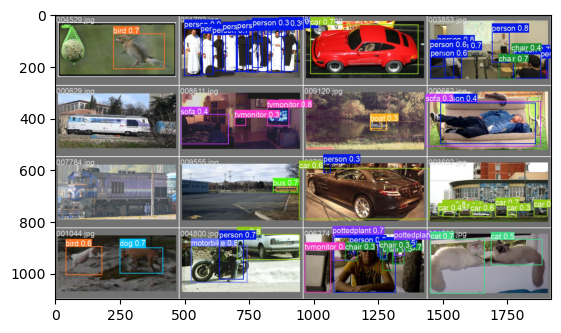

In [10]:
import cv2
import matplotlib.pyplot as plt

im2 = cv2.imread('runs/val/exp/val_batch1_pred.jpg')

im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

plt.imshow(im2)
plt.show()